# 2) New Wake discretisation strategy

SHARPy offers a new wake panelling discretisation method where the panels grow in size further away from the body. This retains the wake length (which is essential in converging solutions) yet at a fraction of the cost, since the panels that are further away, and thus have less influence on the bound panels, are much larger.

This new wake is implemented in both the nonlinear and linear UVLM modules through a wake generator defined in `AerogridLoader`.

In this tutorial, we will implement the new wake shape to the HALE aircraft and compare a few metrics against a wake with constant panel discretisation. It is recommended that users run their own convergence studies on the wake discretisation to achive the desired size against accuracy.

The description of other solvers not related to the wake generation will be brief and the reader is referred to other tutorials and the SHARPy documentation for full details.

In [1]:
import aircraft
import sharpy.utils.algebra as algebra
import numpy as np

For this simple tutorial we'll evaluate a few metrics comparing the constant panel wake (hereinafter CFL1 case) and the growing wake panel case (CFLN), namely the trim condition and the eigenvalues of the linearised system about said trim condition.

We'll start by creating two hale aircraft which will have the same `.fem.h5` and `.aero.h5` files and `.sharpy` settings with the exception of the `AerogridLoader` solver, which contains the information on how to build the wake.

In [2]:
# Simulation
case_name = ['hale_cfl1', 'hale_cfln']
cases_route = './cases/'
output_route = './output/'

# Flight conditions
u_inf = 10
rho = 1.225

# will be overwritten by Trim Routine
alpha = 3.4425 * np.pi / 180
elevator = -0.0991 * np.pi / 180
thrust = 4.2186

# Discretisation
m = 4
n_elem_multiplier = 1.5
wake_length = 10
horseshoe = False
tolerance = 1e-5

In [3]:
hangar = []
for case in case_name:
    hale = aircraft.Hale(case, cases_route, output_route)

    hale.clean()

    hale.init_structure()
    hale.init_aero(m)

    hale.set_flight_controls(thrust=thrust, elevator=elevator)
    hale.generate()
    
    # Derived parameters
    dt = hale.aero.chord_main / m / u_inf

    hale.settings = dict()
    
    hangar.append(hale)
    
    hale.settings['SHARPy'] = {'case': hale.case_name,
                          'route': hale.case_route,
                          'flow': ['BeamLoader',
                                   'AerogridLoader',
                                   'StaticTrim',
                                   'AerogridPlot',
                                   'DynamicCoupled',
                                   'Modal',
                                   'LinearAssembler',
                                   'AsymptoticStability'
                              ],
                      'write_screen': 'on',
                      'write_log': 'on',
                      'log_folder': hale.output_route,
                      'log_file': hale.case_name + '.log'}
    
    hale.settings['BeamLoader'] = {'unsteady': 'on',
                          'orientation': algebra.euler2quat(np.array([0.,
                                                                      alpha,
                                                                      0.]))}

    hale.settings['NonLinearStatic'] = {'print_info': 'off',
                               'max_iterations': 150,
                               'num_load_steps': 1,
                               'delta_curved': 1e-1,
                               'min_delta': tolerance,
                               'gravity_on': 'on',
                               'gravity': 9.81,
                               'initial_position': [0., 0., 0.]}
    hale.settings['AerogridPlot'] = {}

    hale.settings['StaticUvlm'] = {'print_info': 'on',
                          'horseshoe': horseshoe,
                          'num_cores': 4,
                          'n_rollup': 0,
                          'rollup_dt': dt,
                          'rollup_aic_refresh': 1,
                          'rollup_tolerance': 1e-4,
                          'velocity_field_generator': 'SteadyVelocityField',
                          'velocity_field_input': {'u_inf': u_inf,
                                                   'u_inf_direction': [1., 0, 0]},
                          'rho': rho}

    hale.settings['StaticCoupled'] = {'print_info': 'off',
                             'structural_solver': 'NonLinearStatic',
                             'structural_solver_settings': hale.settings['NonLinearStatic'],
                             'aero_solver': 'StaticUvlm',
                             'aero_solver_settings': hale.settings['StaticUvlm'],
                             'max_iter': 100,
                             'n_load_steps': 1,
                             'tolerance': tolerance,
                             'relaxation_factor': 0.2}

    hale.settings['StaticTrim'] = {'solver': 'StaticCoupled',
                          'solver_settings': hale.settings['StaticCoupled'],
                          'initial_alpha': alpha,
                          'initial_deflection': elevator,
                          'initial_thrust': thrust,
                          'fz_tolerance': 0.1,
                          'fx_tolerance': 0.1,
                          'm_tolerance': 0.1,
                          'save_info': 'on',
                          }
    struct_solver_settings = {'print_info': 'off',
                          'initial_velocity_direction': [-1., 0., 0.],
                          'max_iterations': 950,
                          'delta_curved': 1e-6,
                          'min_delta': tolerance,
                          'newmark_damp': 5e-3,
                          'gravity_on': 'on',
                          'gravity': 9.81,
                          'num_steps': 1,
                          'dt': dt,
                          'initial_velocity': u_inf * 1}

    step_uvlm_settings = {'print_info': 'on',
                          'horseshoe': 'off',
                          'num_cores': 4,
                          'n_rollup': 1,
                          'convection_scheme': 2,
                          'rollup_dt': dt,
                          'vortex_radius': 1e-6,
                          'rollup_aic_refresh': 1,
                          'rollup_tolerance': 1e-4,
                          'velocity_field_generator': 'SteadyVelocityField',
                          'velocity_field_input': {'u_inf': u_inf * 0,
                                                   'u_inf_direction': [1., 0., 0.]},
                          'rho': rho,
                          'n_time_steps': 1,
                          'dt': dt,
                          'gamma_dot_filtering': 3}

    hale.settings['DynamicCoupled'] = {'print_info': 'on',
                                  'structural_solver': 'NonLinearDynamicCoupledStep',
                                  'structural_solver_settings': struct_solver_settings,
                                  'aero_solver': 'StepUvlm',
                                  'aero_solver_settings': step_uvlm_settings,
                                  'fsi_substeps': 200,
                                  'fsi_tolerance': tolerance,
                                  'relaxation_factor': 0.3,
                                  'minimum_steps': 1,
                                  'relaxation_steps': 150,
                                  'final_relaxation_factor': 0.5,
                                  'n_time_steps': 1,
                                  'dt': dt,
                                  'include_unsteady_force_contribution': 'off'}
    hale.settings['Modal'] = {'rigid_body_modes': 'on'}  # This will ensure the rigid body modes are captured, 
                                                 # else the analysis will assume a clamped structure

    hale.settings['LinearAssembler'] = {'linear_system': 'LinearAeroelastic',
                                   'linear_system_settings': {
                                       'beam_settings': {'modal_projection': 'on',
                                                         'inout_coords': 'modes',  
                                                         'discrete_time': 'on', 
                                                         'newmark_damp': 0.5e-3,
                                                         'discr_method': 'newmark',
                                                         'dt': dt,
                                                         'proj_modes': 'undamped',
                                                         'use_euler': 'on',  
                                                         'num_modes': 20,
                                                         'print_info': 'off',
                                                         'gravity': 'on',
                                                         'remove_dofs': [],
                                                         'remove_rigid_states': 'off'  
                                                        },
                                       'aero_settings': {'dt': dt,
                                                         'integr_order': 2,
                                                         'density': rho,
                                                         'remove_predictor': 'off',
                                                         'use_sparse': False,
                                                         'vortex_radius': 1e-7,
                                                         'remove_inputs': ['u_gust'],  
                                                         'convert_to_ct': 'off',  
                                                         },
                                       'linearisation_tstep': -1
                                    }
                                   }
    hale.settings['AsymptoticStability'] = {'export_eigenvalues': 'on'}

### Normal Wake

The normal wake where the wake panels are the same size as the bound panels is generated as usual. (Note, since SHARPy 1.2 the wake generation is performed in the `AerogridLoader` solver and by inputting the minimum settings as below, the standard wake is built.

In [4]:
hangar[0].settings['AerogridLoader'] = {'unsteady': 'on',
                              'aligned_grid': 'on',
                              'mstar': wake_length * m,
                              'wake_shape_generator': 'StraightWake',
                              'wake_shape_generator_input': {
                                  'u_inf': u_inf,
                                  'u_inf_direction': [1., 0., 0.],
                                  'dt': dt,
                              },
                              }

### Non-constant panel size wake

For non-rotating bodies (i.e. aircraft, clamped wings) the wake is generated using the `StraightWake` generator. Its documentation can be found [here](https://ic-sharpy.readthedocs.io/en/master/includes/generators/straightwake/StraightWake.html).

We basically need to define the size of the first wake panel `dx1` (in this case we set it to be the same size as the bound panels), the number of panels with that size `ndx1`, the growth rate `r` and the maximum panel size `dxmax`.

A convergence study on these parameters is recommended to ensure you obtain the correct accuracy. The wake size will be shown on screen after the `AerogridLoader` solver runs.

In [5]:
hangar[1].settings['AerogridLoader'] = {'unsteady': 'on',
                                        'aligned_grid': 'on',
                                        'mstar': 11,
                                        'wake_shape_generator': 'StraightWake',
                                          'wake_shape_generator_input': {
                                              'u_inf': u_inf,
                                              'u_inf_direction': [1., 0., 0.],
                                              'dt': dt,
                                              'dx1': hale.aero.chord_main/m,  # size of first wake panel. Here equal to bound panel
                                              'ndx1': int((1*hale.aero.chord_main)/(hale.aero.chord_main/m)), 
                                              'r': 1.5,
                                              'dxmax':5*hale.aero.chord_main}
                              }
                              

In [6]:
for acf in hangar:
    acf.create_settings(acf.settings)

In [7]:
hangar[0].run()

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/ng213/2TB/KK_AirbusHALE/Delivery/02_WakePanelling
SHARPy being run is in /home/ng213/2TB/KK_AirbusHALE/src/sharpy
The branch being run is airbus
The version and

/home/ng213/2TB/KK_AirbusHALE/src/sharpy/sharpy/aero/utils/uvlmlib.py:264: RuntimeWarning: invalid value encountered in true_divide
  flightconditions.uinf_direction = np.ctypeslib.as_ctypes(ts_info.u_ext[0][:, 0, 0]/flightconditions.uinf)


|   1   | 0.0250 |  1   |   0.813508   |   0.293974   |  -5.771765   |-9.981035e+00 |-6.152604e-01 |
...Finished
Generating an instance of Modal
Variable print_info has no assigned value in the settings file.
    will default to the value: True
Variable use_undamped_modes has no assigned value in the settings file.
    will default to the value: True
Variable NumLambda has no assigned value in the settings file.
    will default to the value: 20
Variable keep_linear_matrices has no assigned value in the settings file.
    will default to the value: True
Variable write_modes_vtk has no assigned value in the settings file.
    will default to the value: True
Variable print_matrices has no assigned value in the settings file.
    will default to the value: False
Variable write_dat has no assigned value in the settings file.
    will default to the value: True
Variable continuous_eigenvalues has no assigned value in the settings file.
    will default to the value: False
Variable dt has no

/home/ng213/2TB/KK_AirbusHALE/src/sharpy/sharpy/solvers/modal.py:269: UserWarning: Projecting a system with damping on undamped modal shapes
  warnings.warn('Projecting a system with damping on undamped modal shapes')
/home/ng213/2TB/KK_AirbusHALE/src/sharpy/sharpy/structure/utils/modalutils.py:469: ComplexWarning: Casting complex values to real discards the imaginary part
  phi_rr[:, index_mode] = eigenvectors[-num_rigid_modes:, i]


			...done in 0.49 sec
State-space realisation of UVLM equations started...
Computing wake propagation matrix with CFL1=True
	state-space model produced in form:
	x_{n+1} = A x_{n} + Bp u_{n+1}
			...done in 2.77 sec
Generating an instance of LinearBeam
Variable remove_sym_modes has no assigned value in the settings file.
    will default to the value: False


/home/ng213/2TB/KK_AirbusHALE/src/sharpy/sharpy/linear/assembler/linearaeroelastic.py:264: ComplexWarning: Casting complex values to real discards the imaginary part
  in_mode_matrix[:2*beam.sys.num_dof, :2*beam.sys.num_modes] = sclalg.block_diag(phi, phi)


Aeroelastic system assembled:
	Aerodynamic states: 2184
	Structural states: 40
	Total states: 2224
	Inputs: 64
	Outputs: 60
Final system is:
State-space object
States: 2224
Inputs: 64
Outputs: 60
dt: 0.025
Input Variables:
	(InputVariable: q, size: 20, index: 0, starting at: 0, finishing at: 20)
	(InputVariable: q_dot, size: 20, index: 1, starting at: 20, finishing at: 40)
        (InputVariable: control_surface_deflection, size: 2, index: 2, starting
at: 40, finishing at: 42)
        (InputVariable: dot_control_surface_deflection, size: 2, index: 3,
starting at: 42, finishing at: 44)
	(InputVariable: Q, size: 20, index: 4, starting at: 44, finishing at: 64)
State Variables:
	(StateVariable: gamma, size: 168, index: 0, starting at: 0, finishing at: 168)
        (StateVariable: gamma_w, size: 1680, index: 1, starting at: 168,
finishing at: 1848)
        (StateVariable: dtgamma_dot, size: 168, index: 2, starting at: 1848,
finishing at: 2016)
        (StateVariable: gamma_m1, size: 168, i

The panel details for the CFL1 are:

  * In total: 168 bound panels
  * In total: 1680 wake panels
  * Total number of panels = 1848

In [8]:
hangar[1].run()

--------------------------------------------------------------------------------
            ######  ##     ##    ###    ########  ########  ##    ##
           ##    ## ##     ##   ## ##   ##     ## ##     ##  ##  ##
           ##       ##     ##  ##   ##  ##     ## ##     ##   ####
            ######  ######### ##     ## ########  ########     ##
                 ## ##     ## ######### ##   ##   ##           ##
           ##    ## ##     ## ##     ## ##    ##  ##           ##
            ######  ##     ## ##     ## ##     ## ##           ##
--------------------------------------------------------------------------------
Aeroelastics Lab, Aeronautics Department.
    Copyright (c), Imperial College London.
    All rights reserved.
    License available at https://github.com/imperialcollegelondon/sharpy
Running SHARPy from /home/ng213/2TB/KK_AirbusHALE/Delivery/02_WakePanelling
SHARPy being run is in /home/ng213/2TB/KK_AirbusHALE/src/sharpy
The branch being run is airbus
The version and

/home/ng213/2TB/KK_AirbusHALE/src/sharpy/sharpy/aero/utils/uvlmlib.py:264: RuntimeWarning: invalid value encountered in true_divide
  flightconditions.uinf_direction = np.ctypeslib.as_ctypes(ts_info.u_ext[0][:, 0, 0]/flightconditions.uinf)


|   1   | 0.0250 |  3   |   0.905565   |   0.510165   |  -5.168326   |-9.981310e+00 |-6.106987e-01 |
...Finished
Generating an instance of Modal
Variable print_info has no assigned value in the settings file.
    will default to the value: True
Variable use_undamped_modes has no assigned value in the settings file.
    will default to the value: True
Variable NumLambda has no assigned value in the settings file.
    will default to the value: 20
Variable keep_linear_matrices has no assigned value in the settings file.
    will default to the value: True
Variable write_modes_vtk has no assigned value in the settings file.
    will default to the value: True
Variable print_matrices has no assigned value in the settings file.
    will default to the value: False
Variable write_dat has no assigned value in the settings file.
    will default to the value: True
Variable continuous_eigenvalues has no assigned value in the settings file.
    will default to the value: False
Variable dt has no

/home/ng213/2TB/KK_AirbusHALE/src/sharpy/sharpy/solvers/modal.py:269: UserWarning: Projecting a system with damping on undamped modal shapes
  warnings.warn('Projecting a system with damping on undamped modal shapes')
/home/ng213/2TB/KK_AirbusHALE/src/sharpy/sharpy/structure/utils/modalutils.py:469: ComplexWarning: Casting complex values to real discards the imaginary part
  phi_rr[:, index_mode] = eigenvectors[-num_rigid_modes:, i]


			...done in 0.40 sec
State-space realisation of UVLM equations started...
Computing wake propagation matrix with CFL1=True
	state-space model produced in form:
	x_{n+1} = A x_{n} + Bp u_{n+1}
			...done in 2.24 sec
Generating an instance of LinearBeam
Variable remove_sym_modes has no assigned value in the settings file.
    will default to the value: False


/home/ng213/2TB/KK_AirbusHALE/src/sharpy/sharpy/linear/assembler/linearaeroelastic.py:264: ComplexWarning: Casting complex values to real discards the imaginary part
  in_mode_matrix[:2*beam.sys.num_dof, :2*beam.sys.num_modes] = sclalg.block_diag(phi, phi)


Aeroelastic system assembled:
	Aerodynamic states: 966
	Structural states: 40
	Total states: 1006
	Inputs: 64
	Outputs: 60
Final system is:
State-space object
States: 1006
Inputs: 64
Outputs: 60
dt: 0.025
Input Variables:
	(InputVariable: q, size: 20, index: 0, starting at: 0, finishing at: 20)
	(InputVariable: q_dot, size: 20, index: 1, starting at: 20, finishing at: 40)
        (InputVariable: control_surface_deflection, size: 2, index: 2, starting
at: 40, finishing at: 42)
        (InputVariable: dot_control_surface_deflection, size: 2, index: 3,
starting at: 42, finishing at: 44)
	(InputVariable: Q, size: 20, index: 4, starting at: 44, finishing at: 64)
State Variables:
	(StateVariable: gamma, size: 168, index: 0, starting at: 0, finishing at: 168)
        (StateVariable: gamma_w, size: 462, index: 1, starting at: 168,
finishing at: 630)
        (StateVariable: dtgamma_dot, size: 168, index: 2, starting at: 630,
finishing at: 798)
        (StateVariable: gamma_m1, size: 168, index:

The panel details for the CFLN case are:

*  In total: 168 bound panels
*  In total: 462 wake panels
*  Total number of panels = 630

# Trim values comparison

In [9]:
var_names = ['alpha', 'elevator', 'thrust']
for acf in hangar:
    res = np.loadtxt(acf.output_route + acf.case_name + '/statictrim/trim_values.txt')
    print(acf.case_name)
    print(f'\tAlpha: {res[0] * 180 /np.pi:.4f} deg')
    print(f'\tElevator: {res[1] * 180 /np.pi:.4f} deg ')
    print(f'\tThrust: {res[2]:.4f} N')

hale_cfl1
	Alpha: 3.5276 deg
	Elevator: 3.5927 deg 
	Thrust: 5.5792 N
hale_cfln
	Alpha: 3.4995 deg
	Elevator: 3.6786 deg 
	Thrust: 5.2308 N


# Eigenvalues Comparison

Let's compare the eigenvalues of the linear systems. The resulting state-spaces have the following dimensions (from the system summary printed in the simulation log):

### CFL1
```
Aeroelastic system assembled:
	Aerodynamic states: 2184
	Structural states: 40
	Total states: 2224
	Inputs: 64
	Outputs: 60
Final system is:
State-space object
States: 2224
Inputs: 64
Outputs: 60
dt: 0.025
Input Variables:
	(InputVariable: q, size: 20, index: 0, starting at: 0, finishing at: 20)
	(InputVariable: q_dot, size: 20, index: 1, starting at: 20, finishing at: 40)
        (InputVariable: control_surface_deflection, size: 2, index: 2, starting
at: 40, finishing at: 42)
        (InputVariable: dot_control_surface_deflection, size: 2, index: 3,
starting at: 42, finishing at: 44)
	(InputVariable: Q, size: 20, index: 4, starting at: 44, finishing at: 64)
State Variables:
	(StateVariable: gamma, size: 168, index: 0, starting at: 0, finishing at: 168)
        (StateVariable: gamma_w, size: 1680, index: 1, starting at: 168,
finishing at: 1848)
        (StateVariable: dtgamma_dot, size: 168, index: 2, starting at: 1848,
finishing at: 2016)
        (StateVariable: gamma_m1, size: 168, index: 3, starting at: 2016,
finishing at: 2184)
	(StateVariable: q, size: 20, index: 4, starting at: 2184, finishing at: 2204)
        (StateVariable: q_dot, size: 20, index: 5, starting at: 2204, finishing
at: 2224)
Output Variables:
	(OutputVariable: Q, size: 20, index: 0, starting at: 0, finishing at: 20)
	(OutputVariable: q, size: 20, index: 1, starting at: 20, finishing at: 40)
	(OutputVariable: q_dot, size: 20, index: 2, starting at: 40, finishing at: 60)
```


### CFLN
```
Aeroelastic system assembled:
	Aerodynamic states: 966
	Structural states: 40
	Total states: 1006
	Inputs: 64
	Outputs: 60
Final system is:
State-space object
States: 1006
Inputs: 64
Outputs: 60
dt: 0.025
Input Variables:
	(InputVariable: q, size: 20, index: 0, starting at: 0, finishing at: 20)
	(InputVariable: q_dot, size: 20, index: 1, starting at: 20, finishing at: 40)
        (InputVariable: control_surface_deflection, size: 2, index: 2, starting
at: 40, finishing at: 42)
        (InputVariable: dot_control_surface_deflection, size: 2, index: 3,
starting at: 42, finishing at: 44)
	(InputVariable: Q, size: 20, index: 4, starting at: 44, finishing at: 64)
State Variables:
	(StateVariable: gamma, size: 168, index: 0, starting at: 0, finishing at: 168)
        (StateVariable: gamma_w, size: 462, index: 1, starting at: 168,
finishing at: 630)
        (StateVariable: dtgamma_dot, size: 168, index: 2, starting at: 630,
finishing at: 798)
        (StateVariable: gamma_m1, size: 168, index: 3, starting at: 798,
finishing at: 966)
	(StateVariable: q, size: 20, index: 4, starting at: 966, finishing at: 986)
        (StateVariable: q_dot, size: 20, index: 5, starting at: 986, finishing
at: 1006)
Output Variables:
	(OutputVariable: Q, size: 20, index: 0, starting at: 0, finishing at: 20)
	(OutputVariable: q, size: 20, index: 1, starting at: 20, finishing at: 40)
	(OutputVariable: q_dot, size: 20, index: 2, starting at: 40, finishing at: 60)
```

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (8, 6)
%config InlineBackend.figure_format = 'retina'
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

hale_cfl1
	9: -4.44e-15 + -3.51e-14j
	10: -5.93e-02 + -1.03e-01j
	11: -5.93e-02 + 1.03e-01j
	12: -1.07e-01 + -6.45e+00j
	13: -1.07e-01 + 6.45e+00j
hale_cfln
	9: -1.38e-13 + 4.62e-15j
	10: -5.19e-02 + 1.24e-01j
	11: -5.19e-02 + -1.24e-01j
	12: -1.02e-01 + -6.44e+00j
	13: -1.02e-01 + 6.44e+00j


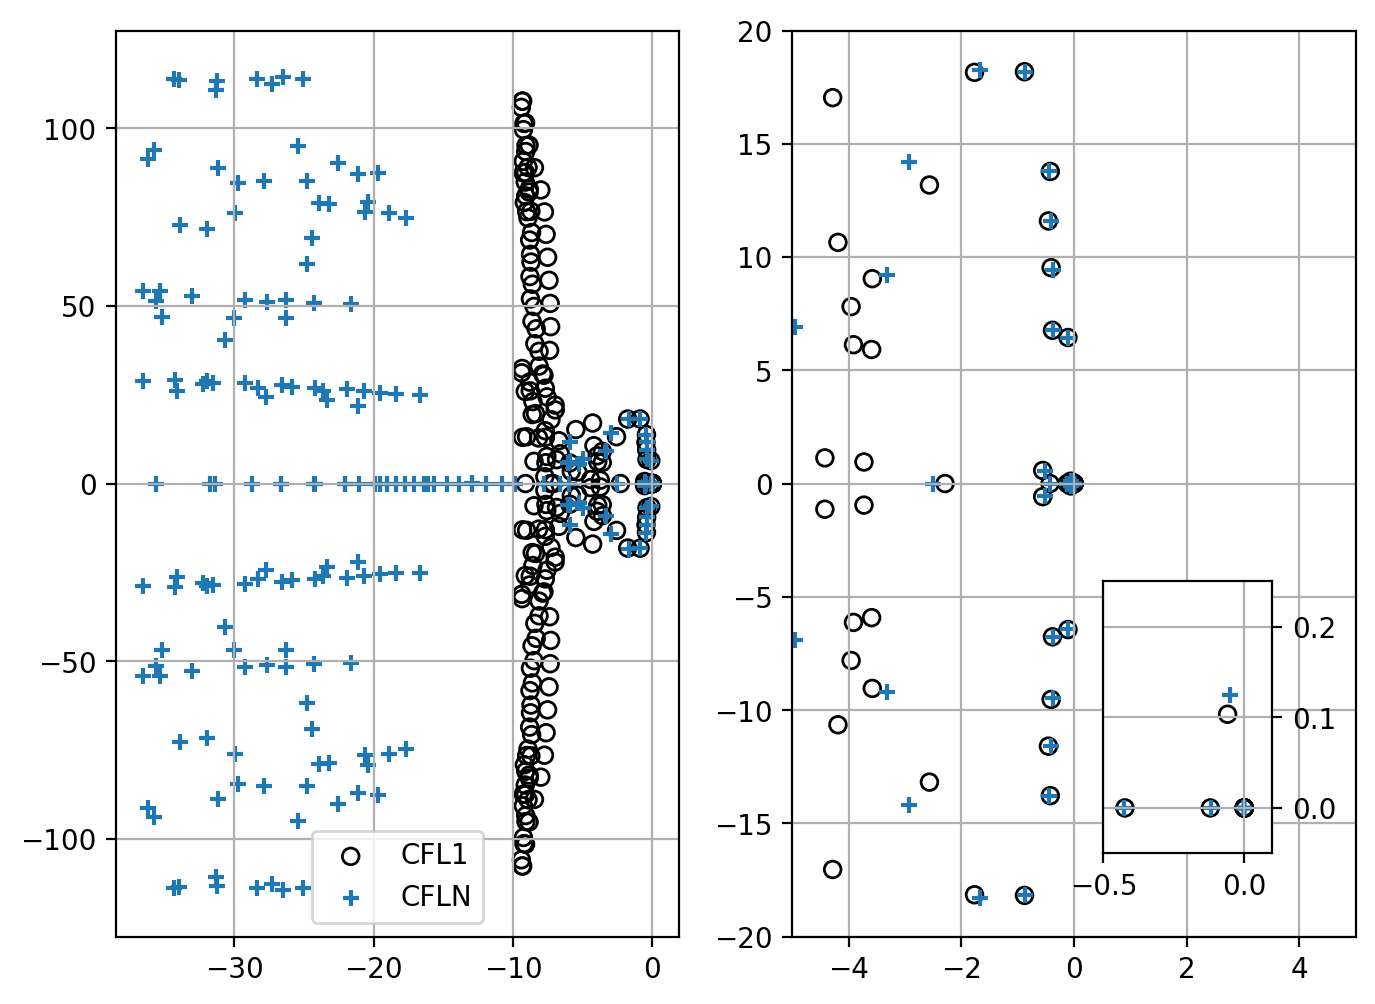

In [11]:
fig, ax = plt.subplots(ncols=2)
markers = [{'marker':'o', 'facecolor': 'none', 'edgecolor': 'k', 'label': 'CFL1'}, 
           {'marker':'+', 'label':'CFLN'}]

axins = inset_axes(ax[1], width='30%', height='30%', loc=4, borderpad=3)

for ith, acf in enumerate(hangar):
    res = np.loadtxt(acf.output_route + acf.case_name + '/stability/eigenvalues.dat')
    ax[0].scatter(res[:, 0], res[:, 1], **markers[ith])
    ax[1].scatter(res[:, 0], res[:, 1], **markers[ith])
    axins.scatter(res[:, 0], res[:, 1], **markers[ith])
    print(acf.case_name)
    eig = 9
    for i in range(5):
        print(f'\t{eig}: {res[eig, 0]:.2e} + {res[eig, 1]:.2e}j')
        eig +=1




ax[0].grid()
ax[1].grid()
ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-20, 20)
axins.set_xlim(-0.5, 0.1)
axins.set_ylim(-0.05, 0.25)
axins.grid()
axins.tick_params(labelright=True, labelleft=False)
axins.tick_params(labelright=True, labelleft=False, right=True, left=False)
ax[0].legend()

Discrepancy between CFL1 mode 9 and CFLN mode 10. Let's see what those modes correspond to:


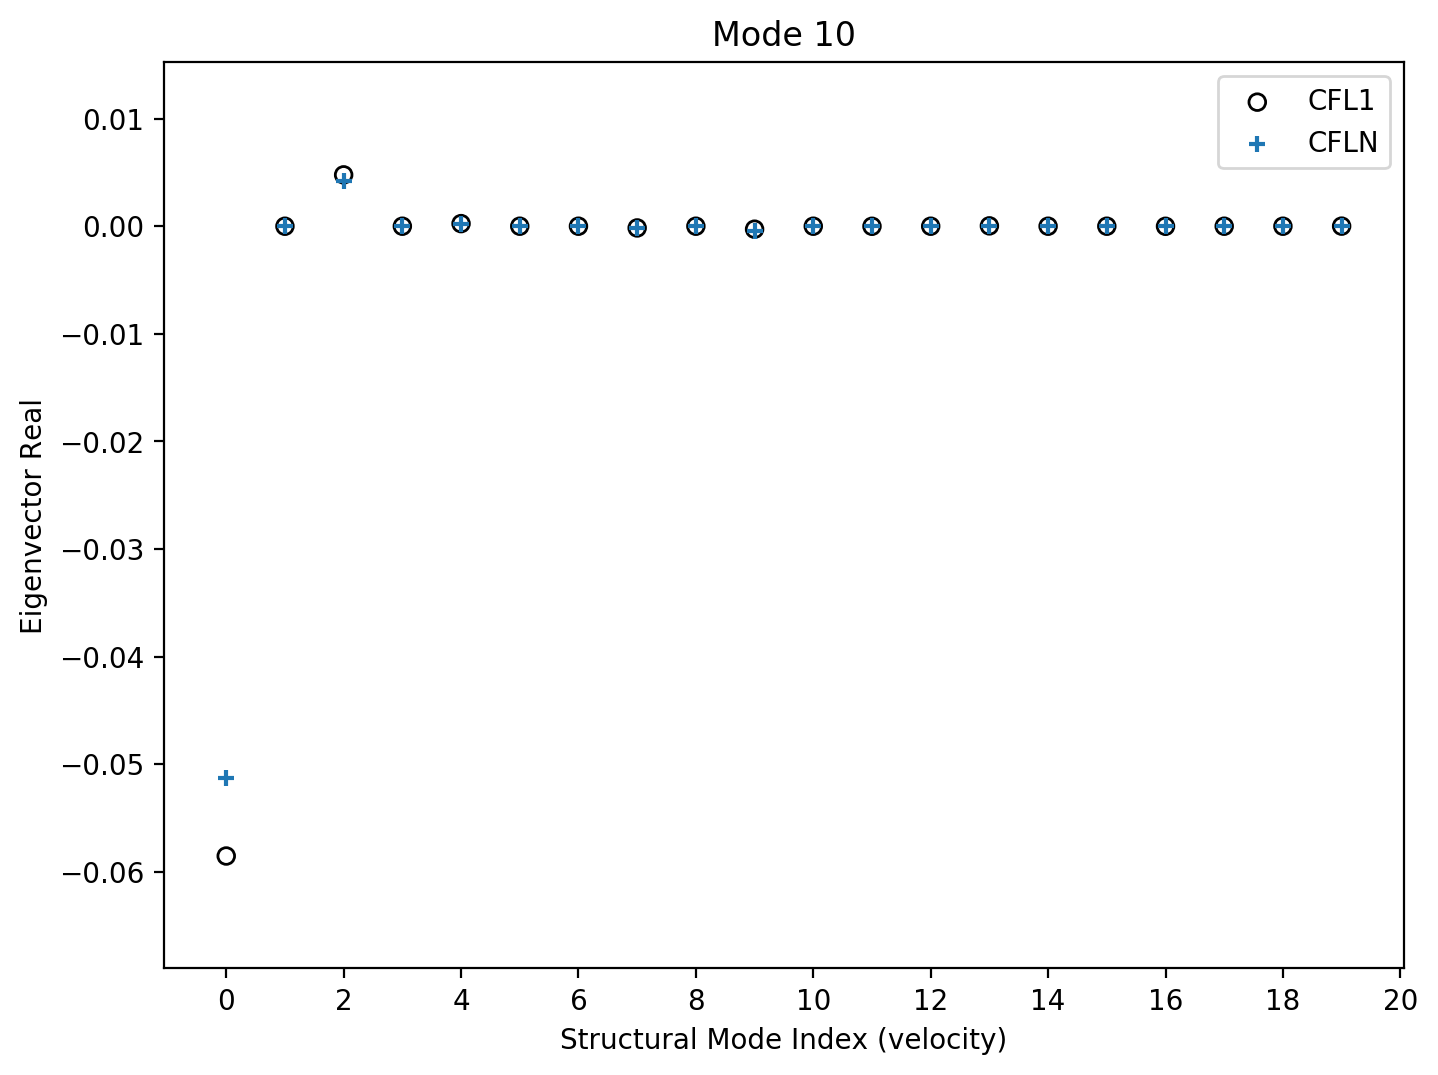

In [12]:
mode = 10
for ith, acf in enumerate(hangar):
    res_r = np.loadtxt(acf.output_route + acf.case_name + '/stability/eigenvectors_r.dat')
    res_i = np.loadtxt(acf.output_route + acf.case_name + '/stability/eigenvectors_r.dat') * 1j
    evecs = res_r + res_i
    
    plt.scatter(np.arange(20), evecs[-20:, mode].real, **markers[ith])

plt.legend()
plt.title('Mode {:g}'.format(mode))
plt.ylabel('Eigenvector Real')
plt.xlabel('Structural Mode Index (velocity)')
plt.xticks(np.arange(0, 21, 2));
plt.xticks(np.arange(0, 21, 2));

Mode 9 appears to be a longitudinal mode dominated by Vx and Vz.

It can be seen there is a slight reduction in accuracy as the wake is less refined (there CFLN case has 4 times less panels than the CFL1 case). However, it should be noted that where this method is really effective is when a very high bound panel discretisation is required to correcly capture the camber of the profile, since that "geometrically-constrained" discretisation requirement is passed onto the wake.